In [1]:
!pip install networkx

In [1]:
# Run if working locally
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.wikisection_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)

from src.dataset.utils import truncate_by_token, flatten, dedupe_list, truncate_string
from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords, Keyword
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint


from utils.metrics import windowdiff, pk
import networkx as nx
import torch

/Users/mac/miniforge3/envs/phd/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/mac/miniforge3/envs/phd/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [214]:
dataset_type = "city"
table = Table(dataset_type)

num_sentences = 30
offset = 0
max_segment_length = 5

all_segments = table.get_all_segments()

segments = [[y[1] for y in x][:max_segment_length] for x in all_segments]
segments_labels = [
    [1 if i == 0 else 0 for i, y in enumerate(x)][:max_segment_length] for x in all_segments
]

flattened_segments = flatten(segments)
flattened_labels = flatten(segments_labels)

segments_to_test = flattened_segments[offset:offset+num_sentences]
labels_to_test = flattened_labels[offset:offset+num_sentences]

Using dataset: wikisection_city


In [503]:
import networkx as nx
import matplotlib.pyplot as plt
import uuid

class CoherenceNode():
    def __init__(self, word, vector, importance, distance=0):
        self.id = uuid.uuid1()
        self.word = word
        self.vector = vector
        self.importance = importance
        self.distance = distance # distance from current sentence (starts at 0)
        # self.level = level
    
    def __repr__(self):
        return f'Node({self.id}, \'{self.word}\', {self.vector})'
        
    def __str__(self):
        return f'Node(\'{self.word}\')'

class CoherenceGraph(nx.Graph):
    def __init__(self):
        nx.Graph.__init__(self)

    # overriden function to add more functionality to the traditional add_edge function
    def add_edge(self, *args, **kwargs):
        super().add_edge(*args, **kwargs)

    # get a node based on an id
    def get_node_by_id(self, id: str):
        for n, nbrs in self.adj.items():
            if n.id == id:
                return (n, nbrs)
        return None

    # get a node based on a word
    def get_node(self, word: str):
        for n, nbrs in self.adj.items():
            if n.word == word:
                return (n, nbrs)
        return None

    # get an edge between two nodes, which holds its weight
    def get_edge(self, node_one, node_two):
        return self.get_edge_data(node_one, node_two)

    # get all the nodes at a certain distance
    def get_nodes_at_distance(self, distance=0):
        nodes = []
        for n, nbrs in self.adj.items():
            if n.distance == distance:
                nodes.append(n)
        return nodes

    # remove all nodes that don't have any edges
    def prune_isolated_nodes(self):
        isolated_nodes = list(nx.isolates(self))
        self.remove_nodes_from(list(nx.isolates(self)))
        return isolated_nodes

    # remove all nodes beyond the max_depth
    def prune_max_depth(self, max_depth: int):
        pruned_nodes = []
        for n, nbrs in self.adj.items():
            if n.distance >= max_depth:
                pruned_nodes.append(n)

        self.remove_nodes_from(list(pruned_nodes))
        return pruned_nodes

    # add 1 distance to all the nodes in the graph
    # we call this function when we iterate to the next sentence in the segment
    def balance_graph(self):
        for n, _ in self.adj.items():
            n.distance += 1

    # remove all the nodes in the graph beyond a certain point
    # e.g., if nodes get too far away (i.e., are too far from the current sentence)
    def prune_max_distance(self, max_distance: int):
        pruned_nodes = []
        for n, _ in self.adj.items():
            try:
                if n.distance > max_distance:
                    pruned_nodes.append(n)
            except:
                # no shortest path could be found - node is isolated
                pass

        self.remove_nodes_from(list(pruned_nodes))
        return pruned_nodes

    # we want to get all the nodes that have some pathway to the current node
    # so we can gather all the cohesive words and make a word compilation vector.
    def get_all_paths_to_node(self, current_node: CoherenceNode):
        paths = []
        for n in self.nodes():
            for path in nx.all_simple_paths(G, source=current_node, target=n):
                paths.append(path)
        return paths

    def get_chain_vector(self, chain):
        chain_vector = 1
        for node in chain:
            chain_vector *= node.vector * node.importance * (1/(node.distance+1))
        return chain_vector
        
    # get all the paths from the current node backward. 
    def get_chains_to_node(self, current_node: CoherenceNode):
        paths = []
        all_paths = self.get_all_paths_to_node(current_node)

        for path in all_paths:
            current_distance = 0
            path_valid = True
            for node in path:
                if node.distance < current_distance:
                    path_valid = False
                current_distance += 1
            if path_valid:
                paths.append(path)

        return paths

    def get_unique_chains_to_node(self, current_node: CoherenceNode):
        unique_chains = []
        chains = self.get_chains_to_node(current_node)
        for chain in chains:
            for inner_chain in chains:
                different = True
                if chain == inner_chain:
                    different = False
                    continue
                if len(inner_chain) > len(chain):
                    # if inner_chain not in unique_chains:
                    #     unique_chains.append(inner_chain)
                    continue
                for i in reversed(range(0, len(inner_chain))):
                    # print(str(chain[i]), str(inner_chain[i]))
                    if chain[i] != inner_chain[i]:
                        different = True
                        break
                    if chain[i] == inner_chain[i] and i == 0:
                        different = False
                        break
                if not different:
                    continue
                if inner_chain not in unique_chains:
                    unique_chains.append(inner_chain)
        
        # fine all the chains to remove
        chains_to_remove = []
        for j, chain in enumerate(unique_chains):
            for k, inner_chain in enumerate(unique_chains):
                if j == k:
                    # same chain, move forward.
                    break
                if len(chain) <= len(inner_chain):
                    found = False
                    # comparison phase
                    for i in range(0, len(chain)):
                        # check each iteration if each node is the same until the last node
                        # in the original chain.
                        if chain[i] == inner_chain[i] and i == (len(chain)-1):
                            # stopping case
                            chains_to_remove.append(chain)
                        if chain[i] != inner_chain[i]:
                            break
        
                    if found:
                        # move on to next chain
                        break

        unique_chains = [x for x in unique_chains if x not in chains_to_remove]
        return unique_chains
                    

    # debug by printing an easy to read representation of the chain
    # TODO: create new class for chain and override repr
    def print_chain(self, chain, with_weights=True):
        prev_node = None
        for node in chain:
            if prev_node is not None:
                if with_weights:
                    print(str(prev_node), "--", G.get_edge(prev_node, node)["weight"], "--> ", end="")
                else:
                    print(str(prev_node), "--> ", end="")
            prev_node = node
        print(str(node))

In [504]:
G = CoherenceGraph()

### Keywords

In [505]:
model_string="bert-base-uncased"

similarities_lib = Similarities(model_string)
keywords_lib = Keywords(similarities_lib.model, similarities_lib.tokenizer)
embedding_lib = Embedding(
    similarities_lib.model, similarities_lib.tokenizer
)
max_words_per_step = 2
keyword_diversity = 0.3

No sentence-transformers model found with name /Users/mac/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


In [506]:
embedding_technique = (keywords_lib.get_batch_keywords_with_kb_embeddings)

In [507]:
# get all the keywords per sentence and truncate at max number of words
batch_keywords = [
    x[:max_words_per_step]
    for x in embedding_technique(
        segments_to_test,
        diversity=keyword_diversity,
        diverse_keywords=True,
        similar_keywords=False,
    )
]

batch_keywords = [[Keyword(z[0], z[1], z[2]) for z in x] for x in batch_keywords]

In [508]:
def check_similarity(emb1, emb2, coherence_threshold=0.5):
    # check similarity and add to coherent dictionary
    similarity = torch.cosine_similarity(
        emb1.reshape(1, -1), emb2.reshape(1, -1)
    )

    # print(f"Similarity: {similarity}")
    if similarity[0] >= coherence_threshold:
        return True
    return False
    
def get_similarity(emb1, emb2):
    # get similarity and add to coherent dictionary
    return torch.cosine_similarity(
        emb1.reshape(1, -1), emb2.reshape(1, -1)
    )

In [509]:
w1 = batch_keywords[0][0]
w2 = batch_keywords[1][1]

kw1, kw2 = torch.Tensor(w1.embedding), torch.Tensor(w2.embedding) 

check_similarity(kw1, kw2)

True

In [510]:
G = CoherenceGraph()
temp_prev_graph = nx.Graph()
for sentence in batch_keywords[:10]:
    # add 1 distance to each word
    G.balance_graph()
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    for word in sentence:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word.text, word.embedding, word.importance)
        for n in prev_graph.nodes():
            if check_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector), coherence_threshold=0.55):
                temp_graph.add_edge(node, n, weight=get_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector)))
                                    
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

In [511]:
batch_keywords, labels_to_test

([[Keyword('sebastiae' | Imp: 0.5166 | Emb Shape: (768,),
   Keyword('donesebastia' | Imp: 0.5138 | Emb Shape: (768,)],
  [Keyword('igeldo' | Imp: 0.4614 | Emb Shape: (768,),
   Keyword('seashore' | Imp: 0.4349 | Emb Shape: (768,)],
  [Keyword('overcast' | Imp: 0.5029 | Emb Shape: (768,),
   Keyword('precipitation' | Imp: 0.4228 | Emb Shape: (768,)],
  [Keyword('astigarraga' | Imp: 0.5813 | Emb Shape: (768,),
   Keyword('ametzagaña' | Imp: 0.5327 | Emb Shape: (768,)],
  [Keyword('oiasso' | Imp: 0.4494 | Emb Shape: (768,),
   Keyword('varduli' | Imp: 0.4461 | Emb Shape: (768,)],
  [Keyword('hospers' | Imp: 0.422 | Emb Shape: (768,),
   Keyword('1872' | Imp: 0.3329 | Emb Shape: (768,)],
  [Keyword('904707' | Imp: 0.5337 | Emb Shape: (768,),
   Keyword('071032' | Imp: 0.3915 | Emb Shape: (768,)],
  [Keyword('698' | Imp: 0.2902 | Emb Shape: (768,),
   Keyword('census' | Imp: 0.2828 | Emb Shape: (768,)],
  [Keyword('861' | Imp: 0.3098 | Emb Shape: (768,),
   Keyword('594' | Imp: 0.3063 | Em

In [512]:
# nx.draw_shell(G, with_labels = True)

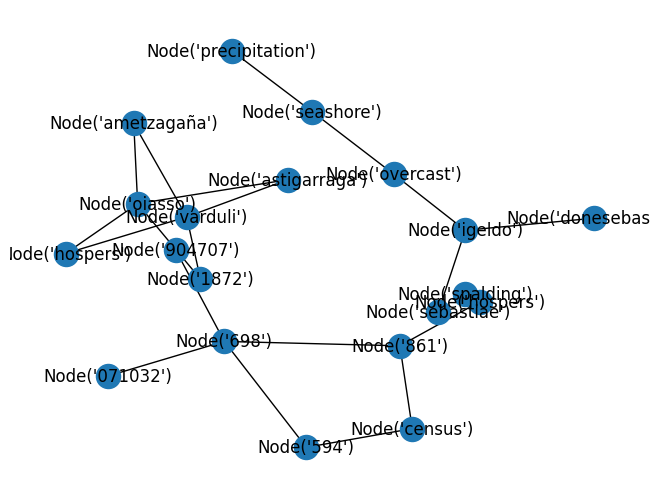

In [513]:
nx.draw_kamada_kawai(G, with_labels = True)

---

### Testing Graph Functionality

In [514]:
nodes = G.get_nodes_at_distance(distance=0)
print([str(n) for n in nodes])

["Node('hospers')", "Node('spalding')"]


In [481]:
# for n in nodes:
#     print([[str(y) for y in x] for x in G.get_all_paths_to_node(n)])

In [515]:
node_to_test = 0
chains = G.get_chains_to_node(nodes[node_to_test])
unique_chains = G.get_unique_chains_to_node(nodes[node_to_test])
len(chains), len(unique_chains)
# chains

# for chain in unique_chains:
#     prev_node = None
#     for node in chain:
#         if prev_node is not None:
#             print(str(prev_node), "--", "--> ", end="")
#         prev_node = node
#     print(str(node))

for chain in chains:
    G.print_chain(chain)

print()
for chain in unique_chains:
    G.print_chain(chain)

Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.7273]) --> Node('904707')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.6695]) --> Node('071032')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.6227]) --> Node('census')
Node('hospers') -- tensor([0.5587]) --> Node('861')

Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.6695]) --> Node('071032')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.6227]) --> Node('census')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.7273]) --> Node('904707')


In [516]:
for chain in chains:
    prev_node = None
    for node in chain:
        if prev_node is not None:
            print(str(prev_node), "--", G.get_edge(prev_node, node)["weight"], "--> ", end="")
        prev_node = node
    print(str(node))

Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.7273]) --> Node('904707')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698') -- tensor([0.6695]) --> Node('071032')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.8989]) --> Node('698')
Node('hospers') -- tensor([0.5587]) --> Node('861') -- tensor([0.6227]) --> Node('census')
Node('hospers') -- tensor([0.5587]) --> Node('861')


---

### Unique Chains Algorithm

In [517]:
unique_chains = []
for chain in chains:
    for inner_chain in chains:
        different = True
        if chain == inner_chain:
            different = False
            continue
        if len(inner_chain) > len(chain):
            # if inner_chain not in unique_chains:
            #     unique_chains.append(inner_chain)
            continue
        for i in reversed(range(0, len(inner_chain))):
            # print(str(chain[i]), str(inner_chain[i]))
            if chain[i] != inner_chain[i]:
                different = True
                break
            if chain[i] == inner_chain[i] and i == 0:
                different = False
                break
        if not different:
            continue
        if inner_chain not in unique_chains:
            unique_chains.append(inner_chain)

# fine all the chains to remove
chains_to_remove = []
for j, chain in enumerate(unique_chains):
    for k, inner_chain in enumerate(unique_chains):
        if j == k:
            # same chain, move forward.
            break
        if len(chain) <= len(inner_chain):
            found = False
            # comparison phase
            for i in range(0, len(chain)):
                # check each iteration if each node is the same until the last node
                # in the original chain.
                if chain[i] == inner_chain[i] and i == (len(chain)-1):
                    # stopping case
                    chains_to_remove.append(chain)
                if chain[i] != inner_chain[i]:
                    break

            if found:
                # move on to next chain
                break

unique_chains = [x for x in unique_chains if x not in chains_to_remove]

for chain in unique_chains:
    prev_node = None
    for node in chain:
        if prev_node is not None:
            print(str(prev_node), "--> ", end="")
        prev_node = node
    print(str(node))

Node('hospers') --> Node('861') --> Node('698') --> Node('071032')
Node('hospers') --> Node('861') --> Node('census')
Node('hospers') --> Node('861') --> Node('698') --> Node('904707')


In [386]:
for i in reversed(range(0, 4)):
    print(i)

3
2
1
0


---

## Prediction Testing

In [351]:
# Number of chains prediction

G = CoherenceGraph()
temp_prev_graph = nx.Graph()
for i, sentence in enumerate(batch_keywords[:num_sentences]):
    # add 1 distance to each word
    G.balance_graph()
    G.prune_max_depth(max_depth=5)
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    for word in sentence:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word.text, word.embedding, word.importance)
        for n in prev_graph.nodes():
            if check_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector), coherence_threshold=0.5):
                temp_graph.add_edge(node, n, weight=get_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector)))
                                    
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

    current_nodes = G.get_nodes_at_distance(distance=0)

    total_chains = 0
    # print([str(n) for n in current_nodes], end=" ")
    for node in current_nodes:
        total_chains += len(G.get_chains_to_node(node))
    print(f"total chains: {total_chains}, label: {labels_to_test[i]}")

["Node('sebastiae')", "Node('donesebastia')"] total chains: 0, label: 1
["Node('igeldo')", "Node('seashore')"] total chains: 4, label: 0
["Node('overcast')", "Node('precipitation')"] total chains: 12, label: 0
["Node('astigarraga')", "Node('ametzagaña')"] total chains: 7, label: 0
["Node('oiasso')", "Node('varduli')"] total chains: 18, label: 0
["Node('hospers')", "Node('1872')"] total chains: 24, label: 1
["Node('904707')", "Node('071032')"] total chains: 18, label: 0
["Node('698')", "Node('census')"] total chains: 16, label: 0
["Node('861')", "Node('594')"] total chains: 20, label: 0
["Node('hospers')", "Node('spalding')"] total chains: 28, label: 0
["Node('cossacks')", "Node('saviour')"] total chains: 33, label: 1
["Node('kharkov')", "Node('counterattacking')"] total chains: 31, label: 0
["Node('kramatorsk')", "Node('sloviansk')"] total chains: 10, label: 0
["Node('decommunization')", "Node('soviet')"] total chains: 8, label: 0
["Node('climate')", "Node('warm')"] total chains: 14, l

In [356]:
# Similarities prediction

G = CoherenceGraph()
temp_prev_graph = nx.Graph()
for i, sentence in enumerate(batch_keywords[:num_sentences]):
    # add 1 distance to each word
    G.balance_graph()
    G.prune_max_depth(max_depth=5)
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    for word in sentence:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word.text, word.embedding, word.importance)
        for n in prev_graph.nodes():
            if check_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector), coherence_threshold=0.5):
                temp_graph.add_edge(node, n, weight=get_similarity(torch.Tensor(n.vector), torch.Tensor(node.vector)))
                                    
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

    current_nodes = G.get_nodes_at_distance(distance=0)
    prev_nodes = G.get_nodes_at_distance(distance=1)

    for prev_node in prev_nodes:
        chains = G.get_chains_to_node(prev_node)
        for current_node in current_nodes:
            for chain in chains:
                chain_vector = chain[1]
                similarity = get_similarity(torch.Tensor(current_node.vector), torch.Tensor(chain_vector))
                print(f"{G.print_chain(chain[0])} || {str(current_node)} sim: {similarity}")

    # total_chains = 0
    # print([str(n) for n in current_nodes], end=" ")
    # for node in current_nodes:
    #     total_chains += len(G.get_chains_to_node(node))
    # print(f"total chains: {total_chains}, label: {labels_to_test[i]}")

Node('igeldo') -- tensor([0.6393]) --> Node('sebastiae')
None || Node('overcast') sim: tensor([-0.3099])
Node('igeldo') -- tensor([0.6931]) --> Node('donesebastia')
None || Node('overcast') sim: tensor([-0.2948])
Node('igeldo') -- tensor([0.6393]) --> Node('sebastiae')
None || Node('precipitation') sim: tensor([-0.2369])
Node('igeldo') -- tensor([0.6931]) --> Node('donesebastia')
None || Node('precipitation') sim: tensor([-0.2095])
Node('seashore') -- tensor([0.5354]) --> Node('sebastiae')
None || Node('overcast') sim: tensor([-0.3230])
Node('seashore') -- tensor([0.5442]) --> Node('donesebastia')
None || Node('overcast') sim: tensor([-0.3088])
Node('seashore') -- tensor([0.5354]) --> Node('sebastiae')
None || Node('precipitation') sim: tensor([-0.2648])
Node('seashore') -- tensor([0.5442]) --> Node('donesebastia')
None || Node('precipitation') sim: tensor([-0.2352])
Node('overcast') -- tensor([0.5847]) --> Node('igeldo') -- tensor([0.6393]) --> Node('sebastiae')
None || Node('astigarr

---

## TESTING

In [252]:
# (id, word_text, vector_representation)

segments = [
    [(0, "hello", 5), (1, "world", 6), (2, "earth", 7)],
    [(3, "school", 3), (4, "work", 5)],
    [(5, "assignments", 6), (6, "deadline", 4), (7, "lazy", 2), (8, "midterms", 5)],
    [(9, "gym", 4.5), (10, "math", 6), (11, "science", 6.5), (12, "world", 2)],
]

In [253]:
# simulation

temp_prev_graph = nx.Graph()
for segment in segments:
    # create a previous graph to hold all the words from the previous sentence
    # such that we can only compare the current words with the previous sentence
    prev_graph = temp_prev_graph
    temp_prev_graph = nx.Graph()
    for word in segment:
        # create a temp graph to hold the edges, which we'll use to compose a new graph
        # after the iteration, since the graph size can't fluctuate as we iterate through
        temp_graph = nx.Graph()
        node = CoherenceNode(word[0], word[1], word[2])
        for n in prev_graph.nodes():
            if n.vector*node.vector >= 20:
                temp_graph.add_edge(node, n, weight=n.vector*node.vector)
        G = nx.compose(G,temp_graph)
        temp_prev_graph.add_node(node)
        # add the node. If it was already added, it won't be added again
        G.add_node(node)

In [254]:
# G.prune_max_depth(1, G.get_node_by_id(0)[0])

In [255]:
for path in nx.all_simple_paths(G, source=G.get_node_by_id(1)[0], target=G.get_node_by_id(4)[0]):
    print(path)

[Node(1, 'world', 6), Node(4, 'work', 5)]


In [256]:
G.get_all_paths_to_node(G.get_node_by_id(4)[0])

[[Node(4, 'work', 5), Node(0, 'hello', 5)],
 [Node(4, 'work', 5), Node(1, 'world', 6)],
 [Node(4, 'work', 5), Node(2, 'earth', 7)],
 [Node(4, 'work', 5), Node(2, 'earth', 7), Node(3, 'school', 3)],
 [Node(4, 'work', 5), Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(8, 'midterms', 5),
  Node(9, 'gym', 4.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(10, 'math', 6),
  Node(8, 'midterms', 5),
  Node(11, 'science', 6.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(8, 'midterms', 5),
  Node(9, 'gym', 4.5),
  Node(5, 'assignments', 6)],
 [Node(4, 'work', 5),
  Node(6, 'deadline', 4),
  Node(11, 'science', 6.5),
  Node(8,

In [257]:
repr(G.get_node_by_id(0))

"(Node(0, 'hello', 5), AtlasView({Node(4, 'work', 5): {'weight': 25}}))"

In [258]:
G.nodes

NodeView((Node(0, 'hello', 5), Node(1, 'world', 6), Node(2, 'earth', 7), Node(3, 'school', 3), Node(4, 'work', 5), Node(5, 'assignments', 6), Node(6, 'deadline', 4), Node(7, 'lazy', 2), Node(8, 'midterms', 5), Node(9, 'gym', 4.5), Node(10, 'math', 6), Node(11, 'science', 6.5), Node(12, 'world', 2)))

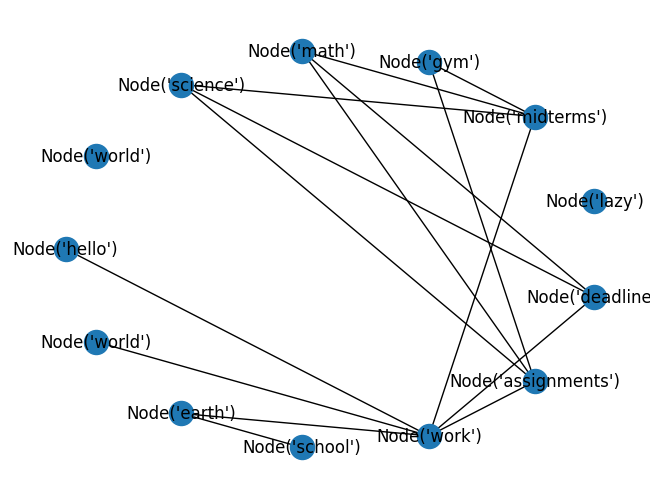

In [262]:
nx.draw_shell(G, with_labels = True)

In [123]:
node, neighbors = G.get_node("hello")

repr(node)

"Node('hello', 5)"

In [116]:
for n in neighbors:
    print(repr(n))

Node('earth', 7)
Node('science', 6.5)


In [117]:
for n in G.edges:
    print(n[0].word, n[1].word)

hello earth
hello science
world earth
world assignments
world math
world science
earth work
earth assignments
earth midterms
earth gym
earth math
earth science
work science
assignments math
assignments science
midterms science
math science


In [118]:
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        print(eattr)
        wt = eattr['weight']
        if wt > 0.5: print(f"({n.word}, {nbr.word}, {wt})")

{'weight': 35}
(hello, earth, 35)
{'weight': 32.5}
(hello, science, 32.5)
{'weight': 42}
(world, earth, 42)
{'weight': 36}
(world, assignments, 36)
{'weight': 36}
(world, math, 36)
{'weight': 39.0}
(world, science, 39.0)
{'weight': 35}
(earth, hello, 35)
{'weight': 42}
(earth, world, 42)
{'weight': 35}
(earth, work, 35)
{'weight': 42}
(earth, assignments, 42)
{'weight': 35}
(earth, midterms, 35)
{'weight': 31.5}
(earth, gym, 31.5)
{'weight': 42}
(earth, math, 42)
{'weight': 45.5}
(earth, science, 45.5)
{'weight': 35}
(work, earth, 35)
{'weight': 32.5}
(work, science, 32.5)
{'weight': 36}
(assignments, world, 36)
{'weight': 42}
(assignments, earth, 42)
{'weight': 36}
(assignments, math, 36)
{'weight': 39.0}
(assignments, science, 39.0)
{'weight': 35}
(midterms, earth, 35)
{'weight': 32.5}
(midterms, science, 32.5)
{'weight': 31.5}
(gym, earth, 31.5)
{'weight': 36}
(math, world, 36)
{'weight': 42}
(math, earth, 42)
{'weight': 36}
(math, assignments, 36)
{'weight': 39.0}
(math, science, 3